In [10]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


In [11]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


In [12]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

# Define the storage directory
persist_directory = "./chroma_db"

# Initialize Chroma with persistence
vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory=persist_directory  # Specify where to store the database
)

print(f"ChromaDB is stored at: {persist_directory}")


/var/folders/3p/s2hzq46x79zbl3zb0t91q2y00000gn/T/ipykernel_53324/881528892.py:8: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


ChromaDB is stored at: ./chroma_db


In [2]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [3]:
from langchain_community.document_loaders import PyPDFLoader

# Load the PDF file
pdf_loader = PyPDFLoader("Undergraduate_Catalog_2024-25.pdf")
documents = pdf_loader.load()

In [7]:
documents[1]

Document(metadata={'source': 'Undergraduate_Catalog_2024-25.pdf', 'page': 1, 'page_label': '2'}, page_content="21818181818\n18191920\n2020\n20\n21\n21\n21\n22\n2223\n232425\n25\n25\n25\n25\n25\n26\n26\n2627\n27\n28\n28\n29\n29\n30\n3031\n31\n32\n32\n32\n32\n323233\n33\n34\n34\n3435\n35\n35\n35\n3535\n35\n36\n36\n36\n36\n36\n36\n36\nTable Of Contents\nTable Of ContentsCalendar 2024/2025FALL SEMESTER 2024SPRING SEMESTER 2025MAYMESTER 2025SUMMER SESSION 2025\nSpecial Programs for UndergraduatesImmersion VanderbiltHoogland Undergraduate Business ProgramThe Undergraduate Business Minor\nBUS Pathways (all courses are 3.0 hours unless otherwise noted)Entrepreneurship\nFinance and Accounting\nMarketing\nOperations\nOrganizational Effectiveness\nStrategy\nBusiness-in-Society ElectivesCourse Descriptions\nUndergraduate Minor in Legal StudiesAir Force Reserve Officer Training Corps (AFROTC)AFROTC Program/Scholarships\nGeneral Benefits\nSponsored Activities\nAerospace Studies Courses at TSU\nFRESH

In [20]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# # Initialize the text splitter
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=1000,  # Number of characters per chunk
#     chunk_overlap=300,  # Overlap between chunks
# )

# # Split the documents
# split_documents = text_splitter.split_documents(documents)
# print(f"Split catalog into {len(split_documents)} sub-documents.")

Split catalog into 1953 sub-documents.


In [9]:
import json
from langchain.schema import Document

# Load chunks from JSON file
with open("chunks.json", "r", encoding="utf-8") as file:
    chunk_data = json.load(file)  # Parse JSON file

# Convert JSON data into LangChain Document objects
split_documents = [
    Document(
        page_content=chunk["text"],  # Extract text content
        metadata={"id": chunk["id"], "page": chunk["metadata"]["page"], "source": "chunks.json"}
    )
    for chunk in chunk_data
]

print(f"Loaded {len(split_documents)} chunks from chunks.json.")

Loaded 1217 chunks from chunks.json.


In [13]:
document_ids = vector_store.add_documents(documents=split_documents)

print(document_ids[:3])

['367ee176-7960-48a4-a612-865a2b66fdc1', 'e9147bcd-1bab-46ac-b5bc-d4b6076ba3eb', '22c74a22-c4cc-44dc-beb7-8c4cabd9f28e']


This completes the Indexing portion of the pipeline. At this point we have a query-able vector store containing the chunked contents of our blog post. Given a user question, we should ideally be able to return the snippets of the catalog that are most relevant to the user's question.

In [18]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()
assert len(example_messages) == 1
print(example_messages[0].content)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/jacobschorr/Documents/RandyCode/fresh_venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [20]:
import os

print(os.getenv("LANGCHAIN_API_KEY"))  # Should print your API key if set


None


In [21]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()
assert len(example_messages) == 1
print(example_messages[0].content)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/jacobschorr/Documents/RandyCode/fresh_venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [29]:
import os
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"

In [31]:
import os

print(os.getenv("LANGSMITH_API_KEY"))

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


In [32]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()
assert len(example_messages) == 1
print(example_messages[0].content)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/jacobschorr/Documents/RandyCode/fresh_venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


We'll use LangGraph to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
We get streamlined deployments via LangGraph Platform.
LangSmith will automatically trace the steps of our application together.
We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.

In [33]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [39]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=8)
    return {"context": retrieved_docs}

retrieve stores retrieved docs from the vector store^

In [35]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

calls the prompt and passes in the context and question to messages, and sends messages to the llm

In [36]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

state object keeping track of everything. retrieve and generate are executed in order and modify the state object. retrieve is connected to the starting point

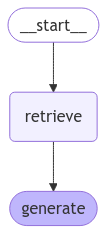

In [37]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
result = graph.invoke({"question": "What math classes are needed for the computer science major?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')